In [2]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 13.2 MB/s eta 0:00:00


In [72]:
import re
import nltk
import csv
import spacy
import numpy as np
import pandas as pd
import contractions
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# import keras_tuner as kt
from sklearn.metrics import classification_report

Prepare csv file from the txt file for ease of access

In [5]:
with open('/content/train_snli.txt') as file:
    data = file.readlines()

with open('data.csv', 'w', newline= '') as csvfile:
    filenames = ['source_txt', 'plagiarism_txt', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=filenames)

    writer.writeheader()
    for line in tqdm(data):
        parts = line.strip().split('\t')
        source_txt = parts[0]
        plagiarism_txt = parts[1]
        label = int(parts[2])

        writer.writerow({
            'source_txt' : source_txt,
            'plagiarism_txt' : plagiarism_txt,
            'label' : label
        })

  0%|          | 0/367373 [00:00<?, ?it/s]

Explore dataset to check any abnormalities

In [14]:
df = pd.read_csv("data.csv")
df.head()

,source_txt,plagiarism_txt,label
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
2,Children smiling and waving at camera,There are children present,1
3,Children smiling and waving at camera,The kids are frowning,0
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0


In [15]:
df.shape

(367373, 3)

Remove missing values

In [16]:
print("Null values count",df.isnull().sum())

Null values count source_txt        0
plagiarism_txt    4
label             0
dtype: int64


In [18]:
null_rows = df[df.isnull().any(axis=1)]
print(null_rows)

                                       source_txt plagiarism_txt  label
61111             Cannot see picture to describe.            NaN      1
61112             Cannot see picture to describe.            NaN      0
207766  Jumping with purple balls is so much fun!            NaN      0
207767  Jumping with purple balls is so much fun!            NaN      1


In [19]:
df.dropna(inplace=True)
print("Null values count:",df.isnull().sum())

Null values count: source_txt        0
plagiarism_txt    0
label             0
dtype: int64


Remove duplicates

In [20]:
print("Duplicates count:", df.duplicated().sum())



Duplicates count: 454


In [24]:
duplicated_rows = df[df.duplicated(keep=False)]

print(duplicated_rows.head())


                                           source_txt          plagiarism_txt  \
1275      Child in red and blue shirt painting a log.  The child is painting.   
1279      Child in red and blue shirt painting a log.  The child is painting.   
1724       Two small dogs run across the green grass.   Two dogs are outside.   
1726       Two small dogs run across the green grass.   Two dogs are outside.   
1951  A young woman is drawing with a Sharpie marker.     A woman is drawing.   

      label  
1275      1  
1279      1  
1724      1  
1726      1  
1951      1  


In [25]:
df.drop_duplicates(inplace=True)
print("Duplicates count:",df.duplicated().sum())

Duplicates count: 0


Check data distribution

label
0    183874
1    183041
Name: count, dtype: int64


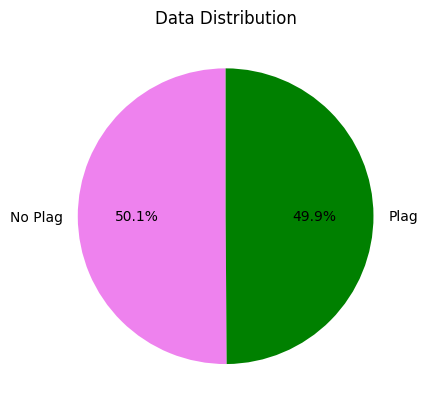

In [34]:
print(df['label'].value_counts())

df['label'].value_counts().plot.pie(labels=['No Plag', 'Plag'],
                                    colors=['violet','green'],
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    textprops={'color':'black'})
plt.title('Data Distribution')
plt.ylabel('')
plt.show()

In [49]:
df=df[:50000]

The data distribution is not skewed. Hence, no need to perform any data balancing.

**Preprocessing**

Convert to lower case

In [50]:
df['source_txt'] = df['source_txt'].str.lower()
df['plagiarism_txt'] = df['plagiarism_txt'].str.lower()


Expand shortforms

In [51]:
df['source_txt'] = df['source_txt'].apply(lambda x: contractions.fix(x) if pd.notnull(x) else x)
df['plagiarism_txt'] = df['plagiarism_txt'].apply(lambda x: contractions.fix(x) if pd.notnull(x) else x)


Remove punctuation marks

In [52]:
df['source_txt'] = df['source_txt'].str.replace(r'[^\w\s]', '', regex=True)
df['plagiarism_txt'] = df['plagiarism_txt'].str.replace(r'[^\w\s]', '', regex=True)


Remove numbers and special characters

In [53]:
df['source_txt'] = df['source_txt'].str.replace(r'[^A-Za-z\s]', '', regex=True)
df['plagiarism_txt'] = df['plagiarism_txt'].str.replace(r'[^A-Za-z\s]', '', regex=True)


Remove extra spacings

In [54]:
df['source_txt'] = df['source_txt'].str.replace(r'\s+', ' ', regex=True).str.strip()
df['plagiarism_txt'] = df['plagiarism_txt'].str.replace(r'\s+', ' ', regex=True).str.strip()


Remove stopwords

In [55]:
nltk.download('stopwords')

nlp = spacy.load('en_core_web_sm')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
df['source_txt'] = df['source_txt'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]) if pd.notnull(x) else x)
df['plagiarism_txt'] = df['plagiarism_txt'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]) if pd.notnull(x) else x)


Apply Lemmatization

In [57]:
tqdm.pandas()

def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df['processed_source_txt'] = df['source_txt'].progress_apply(lambda x: lemmatize(x) if pd.notnull(x) else x)
df['processed_plagiarism_txt'] = df['plagiarism_txt'].progress_apply(lambda x: lemmatize(x) if pd.notnull(x) else x)


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

Final df

In [58]:
df.head()

,source_txt,plagiarism_txt,label,processed_source_txt,processed_plagiarism_txt
0,person horse jumps broken airplane,person diner ordering omelette,0,person horse jump break airplane,person diner order omelette
1,person horse jumps broken airplane,person outdoors horse,1,person horse jump break airplane,person outdoors horse
2,children smiling waving camera,children present,1,child smile wave camera,child present
3,children smiling waving camera,kids frowning,0,child smile wave camera,kid frown
4,boy jumping skateboard middle red bridge,boy skates sidewalk,0,boy jump skateboard middle red bridge,boy skate sidewalk


Compute Embeddings

In [61]:
texts = df['processed_source_txt'].tolist() + df['processed_plagiarism_txt'].tolist()

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

vocab_size = len(tokenizer.word_index) + 1
max_len = max([len(t.split()) for t in texts])

source_seq = pad_sequences(tokenizer.texts_to_sequences(df['processed_source_txt']), maxlen=max_len, padding='post')
plag_seq = pad_sequences(tokenizer.texts_to_sequences(df['processed_plagiarism_txt']), maxlen=max_len, padding='post')

embedding_dim = 100

input_seq = Input(shape=(max_len,))
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(input_seq)
gru_out = GRU(embedding_dim)(embedding)

encoder_model = Model(inputs=input_seq, outputs=gru_out)

source_embeddings = encoder_model.predict(source_seq, verbose=1)
plag_embeddings = encoder_model.predict(plag_seq, verbose=1)

df['source_vec'] = list(source_embeddings)
df['plagiarism_vec'] = list(plag_embeddings)



1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


In [62]:
print(df.head())

                                 source_txt                  plagiarism_txt  \
0        person horse jumps broken airplane  person diner ordering omelette   
1        person horse jumps broken airplane           person outdoors horse   
2            children smiling waving camera                children present   
3            children smiling waving camera                   kids frowning   
4  boy jumping skateboard middle red bridge             boy skates sidewalk   

   label                   processed_source_txt     processed_plagiarism_txt  \
0      0       person horse jump break airplane  person diner order omelette   
1      1       person horse jump break airplane        person outdoors horse   
2      1                child smile wave camera                child present   
3      0                child smile wave camera                    kid frown   
4      0  boy jump skateboard middle red bridge           boy skate sidewalk   

                                          so

In [64]:
X = np.array([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df['source_vec'], df['plagiarism_vec'])])
y = np.array(df['label'].values)

# GRU/LSTM expects 3D input: (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [65]:
num_gru_layers = 2
gru_units = [64, 32]  # Units per layer
dropout_rates = [0.3, 0.2]
dense_units = 64
dense_activation = 'relu'
learning_rate = 0.001
optimizer_choice = 'adam'
batch_size = 32
epochs = 30

In [67]:
model = Sequential()

for i in range(num_gru_layers):
    # For first layer, specify input_shape, others no need
    if i == 0:
        model.add(GRU(units=gru_units[i], return_sequences=(i < num_gru_layers - 1), input_shape=(X_train.shape[1], X_train.shape[2])))
    else:
        model.add(GRU(units=gru_units[i], return_sequences=(i < num_gru_layers - 1)))
    model.add(Dropout(dropout_rates[i]))

model.add(Dense(units=dense_units, activation=dense_activation))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [69]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5458 - loss: 0.6816 - val_accuracy: 0.5869 - val_loss: 0.6582
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5957 - loss: 0.6531 - val_accuracy: 0.5939 - val_loss: 0.6465
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5973 - loss: 0.6460 - val_accuracy: 0.6028 - val_loss: 0.6411
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6045 - loss: 0.6399 - val_accuracy: 0.6006 - val_loss: 0.6422
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6077 - loss: 0.6396 - val_accuracy: 0.6087 - val_loss: 0.6368
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6112 - loss: 0.6368 - val_accuracy: 0.6089 - val_loss: 0.6361
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6123 - loss: 0.6355 - val_accuracy: 0.6156 - val_loss: 0.6375
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6213 - loss: 0.6306 - 

In [70]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6612 - loss: 0.6035

Test Accuracy: 65.29%


In [73]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.61      0.64      5032
           1       0.64      0.70      0.67      4968

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000



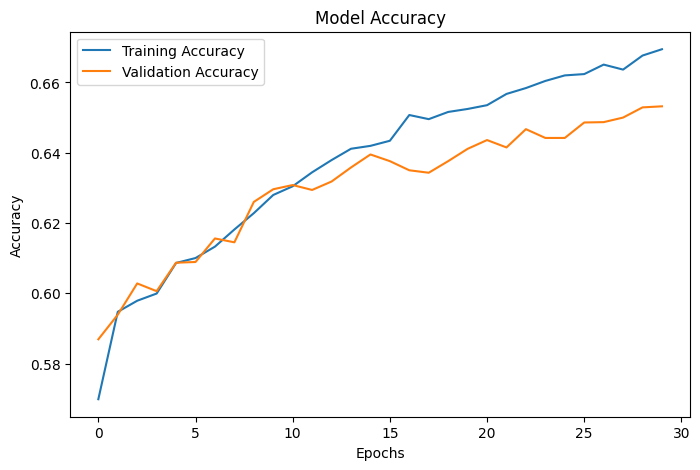

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


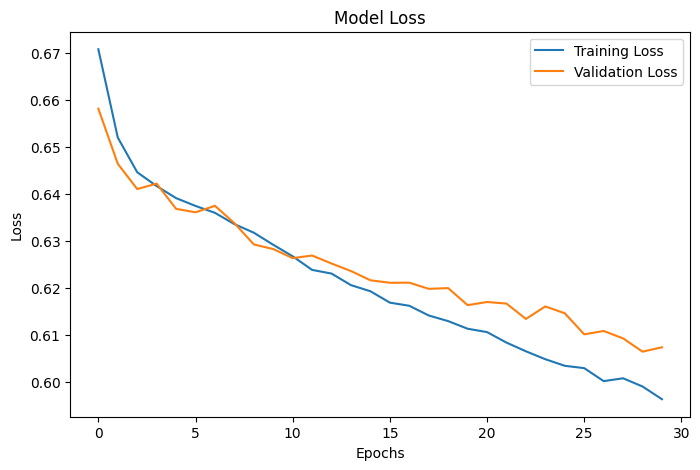

In [75]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [77]:
# Save the GRU model
model.save('best_gru_model.h5')

# Save the tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [83]:
!pip install streamlit pyngrok


In [79]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.7 MB/s eta 0:00:00


In [84]:
%%writefile plagiarism_app.py
import streamlit as st
import pickle
import numpy as np
import tensorflow as tf

# Load model and tokenizer
model = tf.keras.models.load_model('best_gru_model.h5')
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))

# Text preprocessing (same pipeline you used during training)
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def vectorize(text):
    text = preprocess(text)
    sequence = tokenizer.texts_to_sequences([text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=100)
    return padded

# Streamlit UI
st.title("Plagiarism Checker")

source_text = st.text_area("Enter Source Text")
plagiarism_text = st.text_area("Enter Text to Check for Plagiarism")

if st.button("Check"):
    src_vec = vectorize(source_text)
    plag_vec = vectorize(plagiarism_text)
    combined = np.hstack((src_vec, plag_vec))
    combined = combined.reshape((combined.shape[0], 1, combined.shape[1]))

    prediction = model.predict(combined)[0][0]
    st.write("Plagiarism Probability:", round(prediction * 100, 2), "%")

    if prediction > 0.5:
        st.error("Plagiarism Detected")
    else:
        st.success("No Plagiarism Detected")


Writing plagiarism_app.py


In [85]:
from google.colab import files
uploaded = files.upload()


Saving best_gru_model.h5 to best_gru_model (1).h5


In [96]:
!pip install streamlit pyngrok --quiet


In [111]:
!ngrok authtoken 2xI7kcmrCB163gJMaxOB0boKsVj_2BmAAyWGHjQHUxfQhKW1R


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [112]:
!ngrok config add-authtoken 2xI7kcmrCB163gJMaxOB0boKsVj_2BmAAyWGHjQHUxfQhKW1R


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [100]:
%%writefile app.py
import streamlit as st

st.title("Hello from Streamlit in Colab!")

user_input = st.text_input("Enter something:")
st.write("You entered:", user_input)


Overwriting app.py


In [101]:
import time
from pyngrok import ngrok

# Kill any existing tunnels
ngrok.kill()

# Run Streamlit with server.address 0.0.0.0 to accept outside connections
get_ipython().system_raw('streamlit run app.py --server.port 8501 --server.address 0.0.0.0 &')

# Wait for Streamlit to start properly
time.sleep(10)

# Open ngrok tunnel to localhost:8501
public_url = ngrok.connect(8501)
print(f"Streamlit app URL: {public_url}")


Streamlit app URL: NgrokTunnel: "https://6f3b-34-125-144-85.ngrok-free.app" -> "http://localhost:8501"


In [95]:
# Install pyngrok

# Run Streamlit app in background, binding to all IPs
get_ipython().system_raw('streamlit run plagiarism_app.py --server.port 8501 --server.address 0.0.0.0 &')

# Wait to ensure streamlit is ready
import time
time.sleep(10)

# Setup ngrok tunnel
from pyngrok import ngrok

ngrok.kill()
public_url = ngrok.connect("http://localhost:8501")
print(f"Streamlit app running at: {public_url}")


Streamlit app running at: NgrokTunnel: "https://6311-34-125-144-85.ngrok-free.app" -> "http://localhost:8501"


In [109]:
!wget -q -O - ipv4.icanhazip.com

34.125.144.85


In [115]:
! streamlit run plagiarism_app.py & npx localtunnel --port 8501



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.144.85:8501

⠴your url is: https://thirty-foxes-lay.loca.lt
2025-05-19 01:14:38.250258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747617278.267178   41048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747617278.272286   41048 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 01:14:41.831100: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
────────────────────────── T